### __LSTM (Hackathon) | Mohammed Asif Sahadh - 24MSD7061__

Import libraries

In [26]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
import time
import matplotlib.pyplot as plt

Get data

In [2]:
data = pd.read_table(r"sms-spam-collection\SMSSpamCollection")
data.rename(columns = {'ham' : 'temp_label', '''Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...''' : 'sms'}, inplace = True)
data['temp_label'] = data['temp_label'].astype('category')
data['temp_label'] = data['temp_label'].cat.codes # spam:1, ham:0

In [3]:
data.head(5)

,temp_label,sms
0,0,Ok lar... Joking wif u oni...
1,1,Free entry in 2 a wkly comp to win FA Cup fina...
2,0,U dun say so early hor... U c already then say...
3,0,"Nah I don't think he goes to usf, he lives aro..."
4,1,FreeMsg Hey there darling it's been 3 week's n...


Set device to GPU

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Get vocabulary

In [5]:
sms_list = []
for sms in data['sms']:
    sms_list.append(sms)

In [6]:
def get_vocabulory(sms_list):
    wordList = []

    stopWords = set(stopwords.words('english'))
    
    for sentence in sms_list:
        for word in sentence.lower().split():
            if word not in stopWords and word != '':
                wordList.append(word)

    corpus = Counter(wordList)
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    return onehot_dict

sms_vocab = get_vocabulory(sms_list)

Data preprocessing & encoding

In [7]:
def preprocess_data(data):
    X, y = data.loc[:, 'sms'].values, data.loc[:, 'temp_label'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y)
    print(f'X_train {X_train.shape} | X_test {X_test.shape} | y_train {y_train.shape} | y_test {y_test.shape}')
    
    vocab = get_vocabulory(X_train)
    
    new_X_train, new_X_test = [], []
    
    for sentence in X_train:
        new_X_train.append([vocab[word] for word in sentence.lower().split() if word in vocab.keys()])
        
    for sentence in X_test:
        new_X_test.append([vocab[word] for word in sentence.lower().split() if word in vocab.keys()])
    
    le = LabelEncoder()
    new_y_train = le.fit_transform(y_train)
    new_y_test = le.transform(y_test)
    
    return new_X_train, new_X_test, new_y_train, new_y_test, vocab

In [8]:
print('Shapes:')
X_train, X_test, y_train, y_test, vocab = preprocess_data(data)

Shapes:
X_train (4456,) | X_test (1115,) | y_train (4456,) | y_test (1115,)


Apply padding

In [9]:
def padding(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [10]:
X_train = padding(X_train, 100)
X_test = padding(X_test, 100)

Get tensors and load to DataLoader

In [11]:
X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, drop_last = True)

Model definition

In [12]:
def model_def():

    class LSTM(nn.Module):
        def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, output_dim):
            super().__init__()

            self.no_layers = no_layers
            self.hidden_dim = hidden_dim
            self.output_dim = output_dim

            self.embedding = nn.Embedding(vocab_size, embedding_dim)
            self.lstm = nn.LSTM(
                input_size = embedding_dim, 
                hidden_size = hidden_dim, 
                num_layers = no_layers, 
                batch_first = True
            )
            self.dropout = nn.Dropout(.3)
            self.fc = nn.Linear(hidden_dim, output_dim)

        def forward(self, x, hidden):
            x = self.embedding(x)
            x, hidden = self.lstm(x, hidden)
            x =  x[:, -1, :]
            x = self.dropout(x)
            x = self.fc(x)
            return x, hidden

        def init_hidden(self, batch_size):
            h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
            c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
            hidden = (h0,c0)
            return hidden 

    lstm = LSTM (
        no_layers = 2,
        hidden_dim = 64,
        output_dim = 5,
        embedding_dim = 64,
        vocab_size = len(vocab)+1,
    )

    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr = .001)
    
    return lstm, lossfun, optimizer

Model training

In [13]:
def model_train():
    clip = 5 # gradient clipping
    epochs = 5
    
    lstm, lossfun, optimizer = model_def()
    lstm.to(device)
    
    train_acc = []
    train_loss = []
    test_acc = []
    test_loss = []
    
    yTrue = []
    yPred = []
    
    for epochi in range(epochs):
        batchAcc = []
        batchLoss = []
        
        h = lstm.init_hidden(batch_size)
        
        lstm.train()
        
        for X, y in train_dataloader:
            X, y = X.to(device, dtype=torch.int), y.to(device, dtype=torch.long)
            h = tuple([each.data for each in h])
            yHat, h = lstm(X, h)
            
            loss = lossfun(yHat, y)
            
            batchAcc.append(torch.mean((torch.argmax(yHat.cpu(), axis = 1) == y.cpu()).float()))
            batchLoss.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            
            nn.utils.clip_grad_norm_(lstm.parameters(), clip)
            optimizer.step()
        
        train_acc.append(np.mean(batchAcc))
        train_loss.append(np.mean(batchLoss))
        
        lstm.eval()
        
        with torch.no_grad():
            
            h = lstm.init_hidden(batch_size)
        
            batchAcc = []
            batchLoss = []

            for X, y in test_dataloader:
                X, y = X.to(device, dtype=torch.int), y.to(device, dtype=torch.long)
                h = tuple([each.data for each in h])
                yHat, h = lstm(X, h)
                
                yHat = yHat.squeeze()

                loss = lossfun(yHat, y)

                yTrue.extend(y)
                yPred.extend(torch.argmax(yHat.cpu(), axis = 1))

                batchAcc.append(torch.mean((torch.argmax(yHat.cpu(), axis = 1) == y.cpu()).float()))
                batchLoss.append(loss.item())

            test_acc.append(np.mean(batchAcc))
            test_loss.append(np.mean(batchLoss))
        
    return train_acc, test_acc, train_loss, test_loss

In [19]:
start = time.time()
train_acc, test_acc, train_loss, test_loss = model_train()
end = time.time()

print("Training time: {:.2f} seconds".format(end - start))
print("Training accuracy: {:.2f}%".format(train_acc[-1] * 100))
print("Testing accuracy: {:.2f}%".format(test_acc[-1] * 100))

Training time: 2.08 seconds
Training accuracy: 98.67%
Testing accuracy: 97.43%


Loss plot

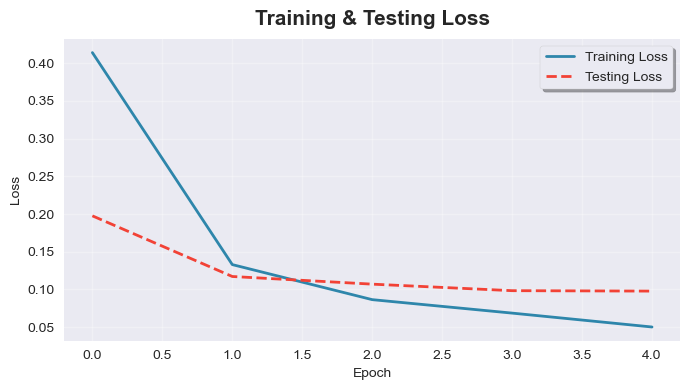

In [33]:
plt.figure(figsize = (7, 4))
plt.style.use('seaborn-v0_8')  

plt.plot(train_loss, label = 'Training Loss', color = '#2E86AB', linewidth = 2)
plt.plot(test_loss, label = 'Testing Loss', color = '#F24236', linewidth = 2, linestyle = '--')

plt.title("Training & Testing Loss", fontsize = 15, fontweight = 'bold', pad = 10)
plt.xlabel("Epoch", fontsize = 10)
plt.ylabel("Loss", fontsize = 10)

plt.legend(frameon = True, fancybox = True, shadow = True)
plt.grid(True, alpha = 0.3)

plt.tight_layout()
plt.show()